# Modelling

The notebook for this tutorial is on path ``xpsi/docs/source/``. The model implemented is the same as the example on path ``xpsi/examples/default_background``. In the penultimate section of this notebook we proceed to synthesise data, by modifying the model to match that found on path ``xpsi/examples/true_background``.

In [1]:
%matplotlib inline

from __future__ import print_function, division

import os
import numpy as np
import math
import time

from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib.ticker import MultipleLocator, AutoLocator, AutoMinorLocator
from matplotlib import gridspec
from matplotlib import cm

import xpsi

from xpsi.global_imports import _c, _G, _M_s, _dpr, gravradius, _csq, _km, _M_s, _2pi

/=============================================\
| X-PSI: X-ray Pulse Simulation and Inference |
|---------------------------------------------|
|                 Version: 0.1                |
|---------------------------------------------|
|  https://thomasedwardriley.github.io/xpsi/  |
\=============================================/



Let's build a generative model for the data; first we build a *callable* object for likelihood evaluation, and then we build a *callable* object for prior-density evaluation.

En route, we will explain why various software design choices were made during development. In some cases the conventions defined are not necessarily important for future development and indeed we expect them to be redesigned.

## Likelihood

If you have not yet read the [likelihood overview](overview.rst), it is advisable to do so now.

### The parameter space

In order to define the X-PSI likelihood it is first necessary to define an underlying model parameter space. In general the parameter space is $\mathbb{R}^{d}$, where $d\in\mathbb{N}$ is the total number of free model parameters, satisfying $d\geq5$ (in the current version, as explicitly shown below).

In X-PSI we define an Abstract Base Class (ABC) representing a [ParameterSubspace](parameterSubspace.rst#xpsi.ParameterSubspace.ParameterSubspace). To construct an X-PSI model a set of objects are defined which *derive* from this parameter subspace ABC, and it is the *union* of these objects that forms both the global model parameter space, and a set of methods and attributes for evaluation of a parametrised sampling distribution of the data at the vector $\mathcal{D}$, conditional on a vector of model parameter values.

Our aim is to construct a *callable* ``likelihood`` object to feed as a *callback* function to a posterior sampler and a posterior integrator. We illustrate this object in the diagram below; all nodes in the diagram below represent objects (instances of some class). In some cases there are multiple instances of a particular class, in other cases there is only a single instance of a particular class. Moreover, a subset of these classes inherit (subclass) the ``ParameterSubspace`` ABC, because instances of these classes are objects defined abstractly by a parameter subspace and a collection of methods with instructions for handling parameter vectors in that subspace (methods and attributes to, e.g., calculate and store some *derived* parameters of the underlying theory/model respectively for likelihood evaluation).

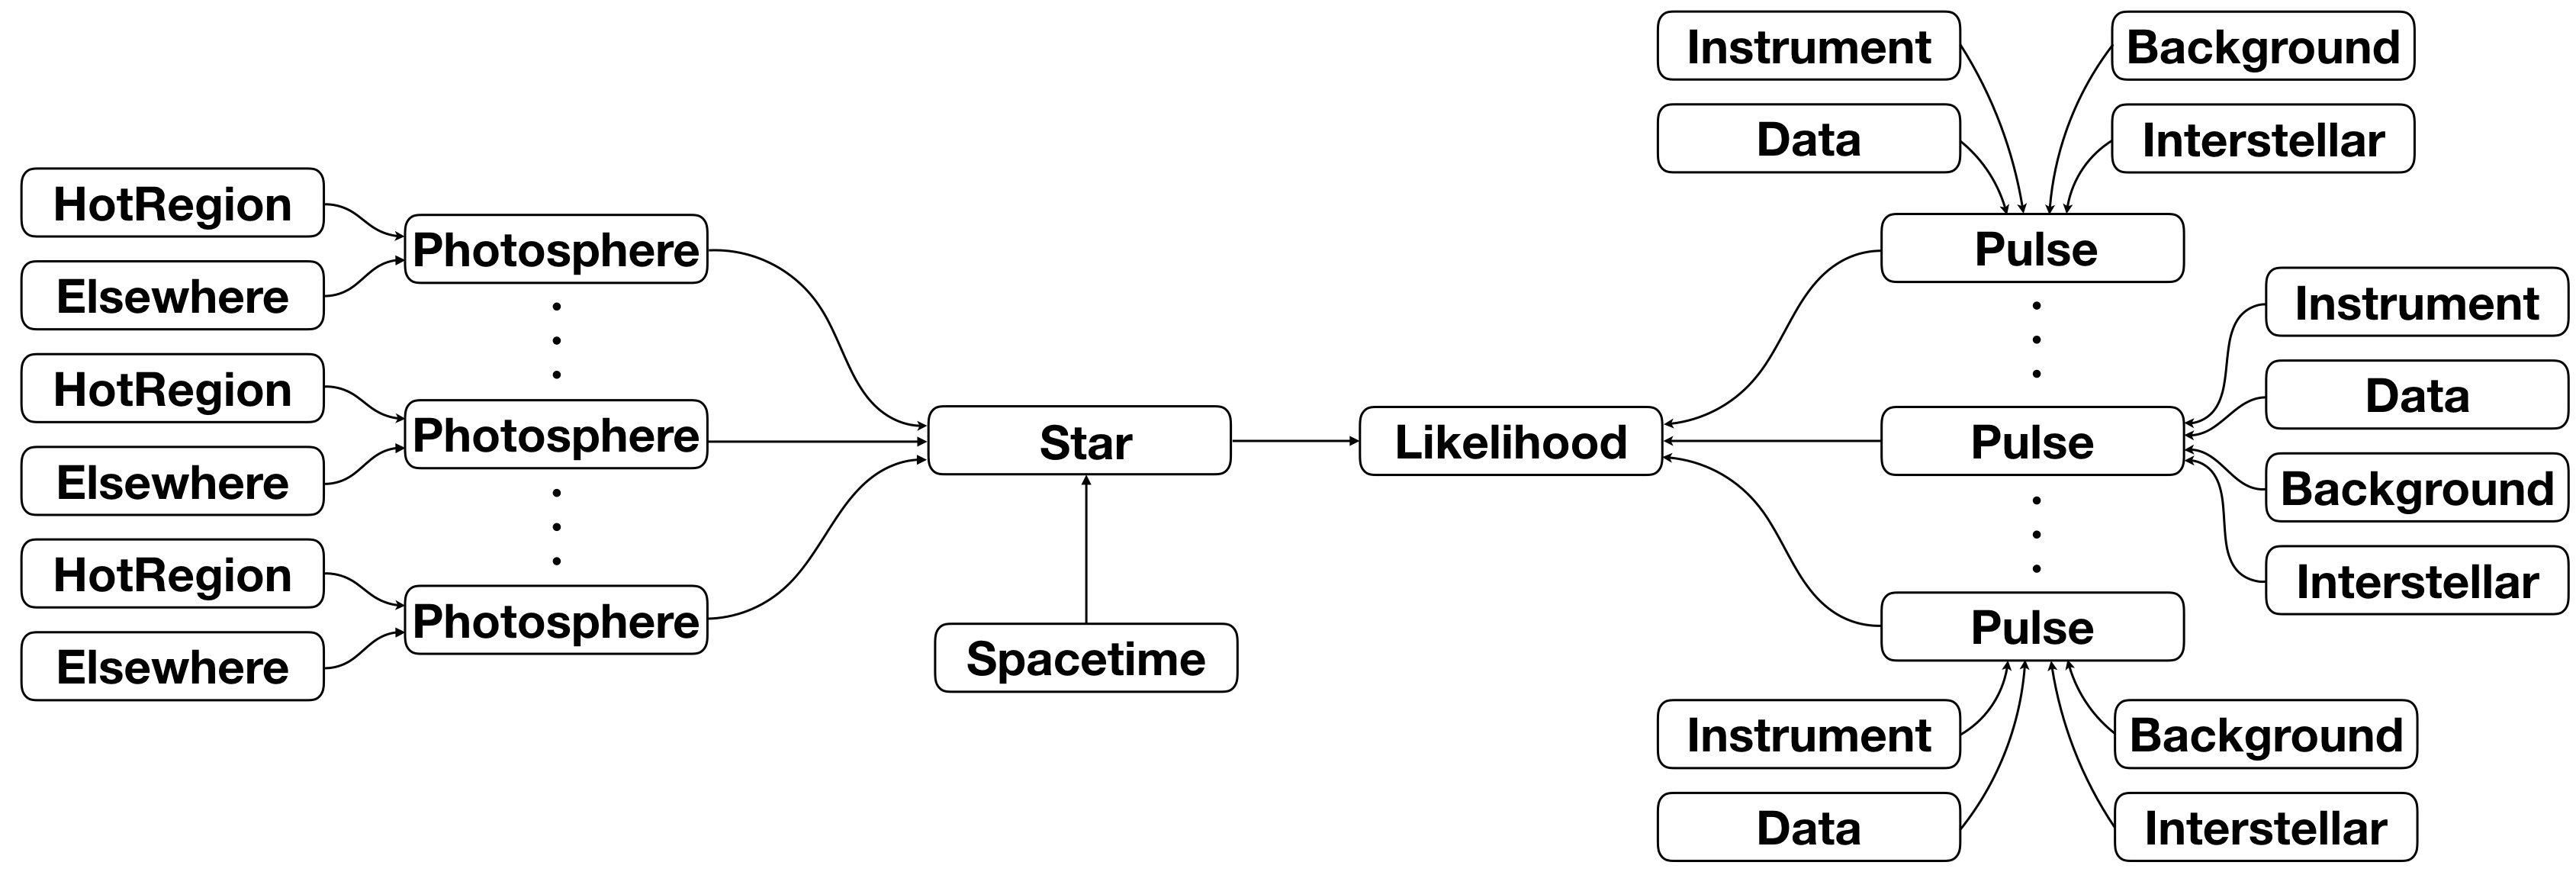

In [2]:
from IPython.display import Image
Image("./_static/oop_modelling_diagram.png")

The arrows in the diagram denote an object that is stored as an attribute of another encapsulating object. The encapsulating object makes calls to methods of the wrapped objects when a call is processed to evaluate the likelihood given a vector of model parameter values. The purpose of exploiting the object-oriented paradigm here is to *organise* a non-trivial likelihood evaluation algorithm in a *logical*, *flexible*, and *extensible* manner by identifying groups of mathematical structures which can be considered as belonging to some more abstract object with some physical and/or statistical meaning. We use a dynamic and expressive high-level language to organise this computation, allowing both calls low-level library routines where necessary to improve calculation speed, and straightforward communication between our problem-specific code and other more general open-source software libraries (in particular, statistical sampling software).

We will now briefly describe the purpose of each object above which is encapsulated by the callable ``likelihood`` object (``Likelihood`` in the diagram to denote the name of the class of which it is an instance).

* A ``Star`` instance does *not* derive from the ``ParameterSubspace`` ABC. It represents the model star. The objects it encapsulates *do* derive from the ``ParameterSubspace`` ABC, and all parameters of these subspaces are *slow* parameters in terms of likelihood evaluation.
    * A ``Spacetime`` instance derives from the ``ParameterSubspace`` ABC, and is itself an ABC. It represents the ambient Schwarzschild spacetime solution.
    * A ``Photosphere`` instance derives from the ``ParameterSubspace`` ABC. It represents a radiation field on a 2-surface embedded in a spacelike hypersurface of that ambient spacetime. There can be multiple ``Photosphere`` instances per ``Star`` instance, naturally representing *snapshots* in time that are assumed to be adequate approximations for some natural number of stellar rotations. Note that the dimensionality of the parameter space grows linearly, however, so in practice this approximation to time evolution is intended for simulation and data synthesis.
        * A ``HotRegion`` instance derives from the ``ParameterSubspace`` ABC. It represents a radiatively intense region: e.g., a "circular hot-spot" in the photosphere (the surface radiation field).
        * An ``Elsewhere`` instance derives from the ``ParameterSubspace`` ABC. The represents the surface radiation field exterior to the hot region.
* A ``Pulse`` instance derives from the ``ParameterSubspace`` ABC, and is itself an ABC. A pulse is defined as a subset   $\mathcal{D}_{i}\subseteq\mathcal{D}$ of the dataset with a parametrised sampling distribution dependent on an
  incident specific flux pulse generated by a particular ``Photosphere`` instance. There can thus be multiple
  ``Pulse`` instances. Moreover, all model parameters in the ``Pulse`` instances, and in the subspaces associated with
  objects that those ``Pulse`` instances encapsulate are *fast* parameters in terms of likelihood evaluation.
    * A ``Data`` instance does *not* derive from the ``ParameterSubspace`` ABC, but is itself an ABC. It is a container
     for the data subset $\mathcal{D}_{i}\subseteq\mathcal{D}$.
    * An ``Instrument`` instance does *not* derive from the ``ParameterSubspace`` ABC, but is itself an ABC. It represents the model instrument for transforming incident specific flux pulses into a structure which directly
      enters the parameterised sampling distribution of $\mathcal{D}_{i}$.
    * An ``Interstellar`` instance derives from the ``ParameterSubspace`` ABC, and is itself an ABC. It represents
      a model for physical interstellar radiation-matter interaction processes which modify the surface radiation
      field during propagation to the instrument.
    * A ``Background`` instance derives from the ``ParameterSubspace`` ABC, and is itself an ABC. It represents a
      model for the background radiation field *incident* on the instrument.

For each of these objects which derive from the ``ParameterSubspace`` class, one needs to specify the number of parameters in the subspace, and define the hard bounds on those parameters upon instantiation.

A subset of model parameters are *slow* because varying those parameters requires *likelihood* re-evaluation, and the compute time required to perform that re-evaluation is slow *relative* to re-evaluation when varying only a distinct *subset* of the model parameters: the *fast* parameters. In general there can be multiple subsets of parameters forming a *speed hierarchy*; see [A. Lewis, "Efficient sampling of fast and slow cosmological parameters" (arXiv:1304.4473)](https://arxiv.org/abs/1304.4473).

X-PSI, during developement, supported the use of the nested sampler PolyChord, whose internals require that parameters forming a speed hierarchy are ordered in subsets (or blocks) from *slow* to *fast* in an array passed to a ``likelihood`` callback function (if one wishes to exploit a speed hierarchy that is). Thus the ordering of an array of parameter values passed to a general instance of the [Likelihood](likelihood.rst#xpsi.Likelihood.Likelihood) class was of crucial importance. During development, we opted to support the nested sampler MultiNest instead based on the nature of the sampling problem (dimensionality and likelihood evaluation expense).

However, for this reason, the source code of X-PSI imposes the following convention for parameter ordering for likelihood evaluation, with a minimum of two speed grades:

1. the *slow* parameters associated with an instance of [Spacetime](spacetime.rst#xpsi.Spacetime.Spacetime);
2. the *slow* parameters associated with each instance of [Photosphere](photosphere.rst#xpsi.Photosphere.Photosphere) and the other objects it encapsulates which derive from the ``ParameterSubspace`` ABC;
5. the *faster* (nuisance) parameters associated with each instance of [Pulse](pulse.rst#xpsi.Pulse.Pulse), and the other objects it encapsulates which derive from the ``ParameterSubspace`` ABC.

Note that the user has complete freedom to extend the speed hierarchy beyond the two *slow-fast* grades in custom classes. Also note that: (i) when a prior-density evaluation call is made, the bounds on all model parameters need to be passed upon instantiation; and (ii) when a likelihood evaluation call is made a parameter vector is handled correctly in terms of passing the correct parameter values to objects, and the property ``Likelihood.bounds`` automatically returns an ordered list of bounds which can be used to instantiate a ``prior`` object.

An exception to this convention is the distance, which although a fast parameter, was later grouped with the spacetime parameters and now appears at the top of the speed hierarchy.

If there are multiple instances of the [Photosphere](photosphere.rst#xpsi.Photosphere.Photosphere) class, and thus multiple instances of the [Pulse](pulse.rst#xpsi.Pulse.Pulse) class (since by definition a one-to-one mapping between is required), the parameter array would assume the following form (with the *non-optional* free parameters in bold):

* distance from Earth
* **(rotationally deformed) gravitational mass**
* **coordinate equatorial radius**
* **inclination of Earth to stellar rotation axis**
* coordinate spin frequency (if not fixed upon star construction)
* ``photosphere_1`` (non-optional):
    * mode/oscillation coordinate rotation frequency (if not locked to stellar rotation; not currently implemented)
    * subvector of geometric **hot-region parameters** (e.g., spot centre colatitude, spot angular radius, and so on) and a parameter controlling the local comoving radiation field *within* the region boundary
    * (optional) subvector of additional parameters controlling the local comoving radiation field *within* the hot-region boundary (e.g., pertaining to ionisation degree or composition)
    * (optional) subvector of parameters controlling the local comoving radiation field *outside* the hot-region boundary
* $\ldots$
* ``photosphere_n`` (optional):
    * mode/oscillation coordinate rotation frequency (if not locked to stellar rotation; not currently implemented)
    * subvector of geometric **hot-region parameters** (e.g., spot centre colatitude, spot angular radius, and so on) and a parameter such as an effective temperature controlling the local comoving radiation field *within* the region boundary
    * (optional) subvector of additional parameters controlling the local comoving radiation field *within* the hot-region boundary (e.g., pertaining to ionisation degree or composition)
    * (optional) subvector of parameters controlling the local comoving radiation field *outside* the hot-region boundary
* ``pulse_1`` (non-optional):
    * (optional) subvector of fast nuisance parameters associated with interstellar processes
    * (optional) subvector of fast nuisance parameters associated with instrument response
    * (optional) subvector of fast nuisance parameters associated with background processes
    * subvector of fast nuisance parameters for the phases of the hot region(s) relative to some fiducial phase
* $\ldots$
* ``pulse_n`` (if matching ``photosphere_n``):
    * (optional) subvector of fast nuisance parameters associated with interstellar processes
    * (optional) subvector of fast nuisance parameters associated with instrument response
    * (optional) subvector of fast nuisance parameters associated with background processes
    * subvector of fast nuisance parameters for the phases of the hot region(s) relative to some fiducial phase
    
where $\forall i\in[1,n]$ ``photosphere_i`` and ``pulse_i`` share an identification ``tag``.

All model parameters not associated with ``Pulse`` instances are *slow* parameters.

For the analysis in this notebook we consider all data $\mathcal{D}$ to be drawn from a joint sampling distribution whose dependency on *slow* model source parameters is expressed in terms of a *single* pulse. The justification for such an assumption is that we are performing parameter estimation given a synthetic data set for a model *pulsar* with a stable (effectively non-evolving) surface radiation field, with any quasi-periodicity arising solely from relative orbital motion of source and telescope. The synthetic data is intended to emulate detection of photons over a long observing run, after which the photon incidence events are phase-folded during a pre-processing phase.

This parameter estimation excercise is not *blind*: we know the parameter values injected to generate the synthetic dataset we will later load into a custom container.

### Data

We are required to write a custom data container. X-PSI is designed this way so that freedom and the scope of applicability of the source code is preserved. We are entirely free to write methods and attributes for this class provided it satisfies two constraints:

* our custom class derives from the class [Data](data.rst#xpsi.Data.Data);
* and a property ``self.channel_range`` returns the first and last channels in the contiguous subset spanned by the data.

If these constraints are satisfied, instances of other X-PSI classes know what to do with the an instance of our data container and will not throw exceptions. The container instance will then be available as an underscore instance method of [Pulse](pulse.rst#xpsi.Pulse.Pulse), and thus available in a derived class where we will later write code for likelihood evaluation.

Hereafter we will write our custom derived classes in the notebook itself, but in practice it is best if your derived classes are written in distinct modules within a project directory, so they can be imported by a script for use with an Open MPI command within a shell (because in general we want to exploit parallelism for expensive likelihood evaluations).

In [3]:
class CustomData(xpsi.Data):
    """ Custom data container. """
    
    def __init__(self, first, last, counts, phases, exposure_time):
        """
        :param counts: A :class:`numpy.ndarray` of count numbers. The rows of
                       the array must map to a contiguous subset of instrument
                       output channels, with the zeroth row corresponding to
                       the :attr:`first` channel, and the last row
                       corresponding to the channel :attr:`last` minus one.
                       The columns must map to the phases given by
                       :obj:`phases`.
        :param phases: A :class:`numpy.ndarray` of phase *edges* of intervals
                       in which the *synthetic* photons arrive.
        :param exposure_time: The total exposure time in seconds.
        
        """
        # Execute parent initialisation code
        super(CustomData, self).__init__(first, last)

        if not isinstance(counts, np.ndarray):
            raise TypeError('Counts object is not a ``numpy.ndarray``.')
        else:
            self._counts = counts

        if self._counts.shape[0] != self._last - self._first:
            raise ValueError('The number of rows must be compatible '
                                 'with the first and last output channel '
                                 'numbers.')

        if not isinstance(phases, np.ndarray):
            raise TypeError('Phases object is not a ``numpy.ndarray``.')
        else:
            self._phases = phases

        self._exposure_time = exposure_time

    @property
    def exposure_time(self):
        """ Get the total exposure time in seconds. """
        return self._exposure_time

    @property
    def counts(self):
        """ Get the photon count data. """
        return self._counts

    @property
    def phases(self):
        """ Get the phases. """
        return self._phases

    @classmethod
    def from_txt(cls, path, **kwargs):
        """ Constructor which loads photon data from a .txt file.
        :param str path: Path to .txt file which is converted into a
                         two-dimensional :class:`numpy.ndarray`.
        """
        try:
            data = np.loadtxt(path, dtype=np.double)
        except (OSError, IOError, TypeError, ValueError):
            print('Data file could not be loaded.')
            raise

        first = 0; last = 181

        phases = np.linspace(0.0, 1.0, 33)

        return cls(first, last, data, phases, **kwargs)

Let us load a synthetic data set that we generated in advance, and know the fictitious exposure time for.

In [4]:
data = CustomData.from_txt('../../examples/data/synthetic_realisation.dat',
                           exposure_time = 984307.6661)

Let's take a look at the data that we aim to model. First we define some settings and helper functions:

In [5]:
rcParams['text.usetex'] = False
rcParams['font.size'] = 14.0

def veneer(x, y, axes, lw=1.0, length=8):
    """ Make the plots a little more aesthetically pleasing. """
    if x is not None:
        if x[1] is not None:
            axes.xaxis.set_major_locator(MultipleLocator(x[1]))
        if x[0] is not None:
            axes.xaxis.set_minor_locator(MultipleLocator(x[0]))
    if y is not None:
        if y[1] is not None:
            axes.yaxis.set_major_locator(MultipleLocator(y[1]))
        if y[0] is not None:
            axes.yaxis.set_minor_locator(MultipleLocator(y[0]))
    else:
        axes.yaxis.set_major_locator(AutoLocator())
        axes.yaxis.set_minor_locator(AutoMinorLocator())
        
    axes.tick_params(which='major', colors='black', length=length)
    axes.tick_params(which='minor', colors='black', length=int(length/2))
    axes.xaxis.set_tick_params(which='both', width=lw)
    axes.yaxis.set_tick_params(which='both', width=lw)
    plt.setp(axes.spines.values(), linewidth=lw, color='black')

def plot_one_pulse(pulse, x, label=r'Counts'):
    """ Plot a pulse resolved over a single rotational cycle. """
    
    fig = plt.figure(figsize = (7,7))

    gs = gridspec.GridSpec(1, 2, width_ratios=[50,1])
    ax = plt.subplot(gs[0])
    ax_cb = plt.subplot(gs[1])

    profile = ax.pcolormesh(x,
                             np.arange(data.channel_range[1])+20,
                             pulse,
                             cmap = cm.magma,
                             linewidth = 0,
                             rasterized = True)

    profile.set_edgecolor('face')

    ax.set_xlim([0.0, 1.0])
    ax.set_yscale('log')
    ax.set_ylabel(r'Channel')
    ax.set_xlabel(r'Phase')

    cb = plt.colorbar(profile,
                      cax = ax_cb)

    cb.set_label(label=label, labelpad=25)
    cb.solids.set_edgecolor('face')

    veneer((0.05, 0.2), (None, None), ax)

    plt.subplots_adjust(wspace = 0.025)

Now for the data:

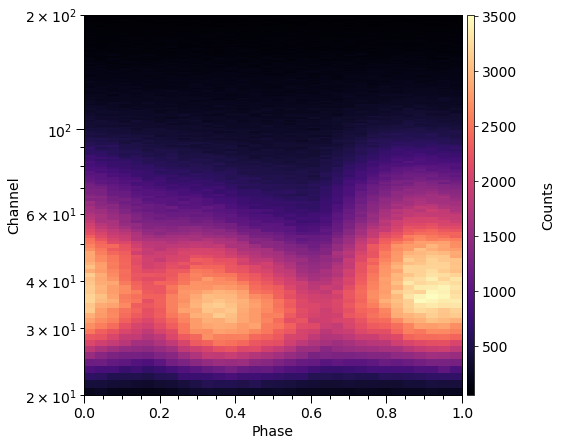

In [6]:
plot_one_pulse(data.counts, data.phases)

### Instrument

We require a model instrument object to transform incident specific flux pulses into a form which enters directly in the sampling distribution of the data.

In [7]:
class CustomInstrument(xpsi.Instrument):
    """ A model of the NICER telescope response.
    
    """
    def __init__(self, channels, channel_edges, *args):
        super(CustomInstrument, self).__init__(*args)
        self._channels = channels
        self._channel_edges = channel_edges

    @property
    def channels(self):
        return self._channels

    @property
    def channel_edges(self):
        """ Get the channel edges. """
        return self._channel_edges

    def construct_matrix(self, p):
        """ Implement response matrix parametrisation. """

        return self.matrix

    def __call__(self, p, signal, *args):
        """ Overwrite. """

        matrix = self.construct_matrix(p)

        self._folded_signal = np.dot(matrix, signal)

        return self._folded_signal

    @classmethod
    def from_response_files(cls, num_params, bounds,
                            ARF, RMF, max_input, min_input=0,
                            channel_edges=None):
        """ Constructor which converts response files into :class:`numpy.ndarray`s.
        :param str ARF: Path to ARF which is compatible with
                                :func:`numpy.loadtxt`.
        :param str RMF: Path to RMF which is compatible with
                                :func:`numpy.loadtxt`.
        :param str channel_edges: Optional path to edges which is compatible with
                                  :func:`numpy.loadtxt`.
        """

        if min_input != 0:
            min_input = int(min_input)

        max_input = int(max_input)

        try:
            ARF = np.loadtxt(ARF, dtype=np.double, skiprows=3)
            RMF = np.loadtxt(RMF, dtype=np.double)
            if channel_edges:
                channel_edges = np.loadtxt(channel_edges, dtype=np.double, skiprows=3)[:,1:]
        except:
            print('A file could not be loaded.')
            raise
            
        matrix = np.ascontiguousarray(RMF[min_input:max_input,20:201].T, dtype=np.double)

        edges = np.zeros(ARF[min_input:max_input,3].shape[0]+1, dtype=np.double)

        edges[0] = ARF[min_input,1]; edges[1:] = ARF[min_input:max_input,2]

        for i in range(matrix.shape[0]):
            matrix[i,:] *= ARF[min_input:max_input,3]

        channels = np.arange(20, 201)

        return cls(channels, channel_edges[20:202,-2],
                   num_params, bounds, matrix, edges)

Let's construct an instance.

In [8]:
NICER = CustomInstrument.from_response_files(num_params=0,
                                             bounds=[],
                                             ARF = '../../examples/model_data/nicer_v1.01_arf.txt',
                                             RMF = '../../examples/model_data/nicer_v1.01_rmf_matrix.txt',
                                             max_input = 500,
                                             min_input = 0,
                                             channel_edges = '../../examples/model_data/nicer_v1.01_rmf_energymap.txt')

The NICER ``v1.01`` response matrix:

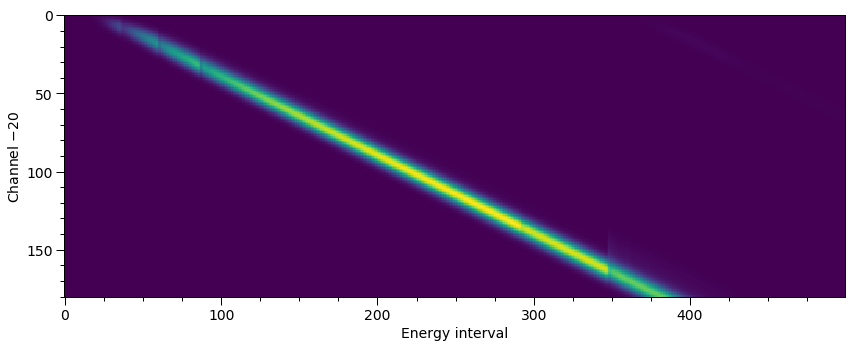

In [9]:
fig = plt.figure(figsize = (14,7))

ax = fig.add_subplot(111)
veneer((25, 100), (10, 50), ax)

_ = ax.imshow(NICER.matrix,
              cmap = cm.viridis,
              rasterized = True)

ax.set_ylabel('Channel $-20$')
_ = ax.set_xlabel('Energy interval')

Summed over channel subset $[20,200]$:

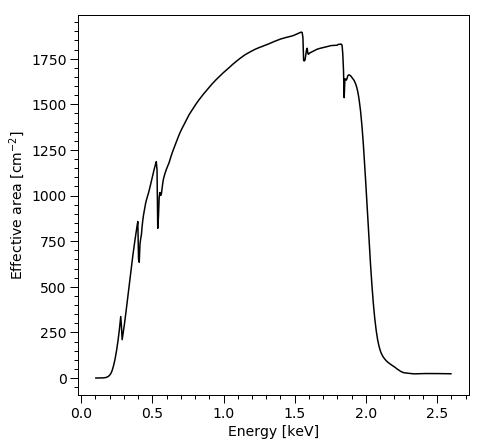

In [10]:
fig = plt.figure(figsize = (7,7))

ax = fig.add_subplot(111)
veneer((0.1, 0.5), (50,250), ax)

ax.plot((NICER.energy_edges[:-1]+NICER.energy_edges[1:])/2.0, np.sum(NICER.matrix, axis=0), 'k-')

ax.set_ylabel('Effective area [cm$^{-2}$]')
_ = ax.set_xlabel('Energy [keV]')

### Pulse

We can now combine the dataset, model instrument, and model background into a [Pulse](pulse.rst#xpsi.Pulse.Pulse) object. The source code for this class has methods and attributes which simplify communication between the aforementioned model facets and an object representing our model star (see below). The surface radiation field of the model star is integrated over when called from a [Pulse](pulse.rst#xpsi.Pulse.Pulse) object which knows which energies to relay based on the properties of the instrument and the dataset (which are tightly coupled).

We are actually forced to inherit from [Pulse](pulse.rst#xpsi.Pulse.Pulse) and write a routine that evaluates the logarithm of the likelihood conditional on a nuisance vector of parameter values and a parametrised sampling distribution for the data. There is much freedom in constructing this sampling distribution, so the design strategy for X-PSI was to leave this part of the modelling process entirely to a user, guided by a number of examples. The only condition of applicability is that the sampling distribution of the data (or of each subset) can be written in terms of a set of *single* count-rate pulses spanning a subset of output channels of the model instrument.

In [11]:
from xpsi.likelihoods.default_background_marginalisation import eval_marginal_likelihood
from xpsi.likelihoods.default_background_marginalisation import precomputation

class CustomPulse(xpsi.Pulse):
    """ A custom calculation of the logarithm of the likelihood.
    We extend the :class:`xpsi.Pulse.Pulse` class to make it callable.
    We overwrite the body of the __call__ method. The docstring for the
    abstract method is copied.
    """

    def __init__(self, workspace_intervals = 1000, epsabs = 0, epsrel = 1.0e-8,
                 epsilon = 1.0e-3, sigmas = 10.0, **kwargs):
        """ Perform precomputation. """

        super(CustomPulse, self).__init__(**kwargs)

        try:
            self._precomp = precomputation(self._data.counts.astype(np.int32))
        except AttributeError:
            print('Warning: No data... can synthesise data but cannot evaluate a '
                  'likelihood function.')
        else:
            self._workspace_intervals = workspace_intervals
            self._epsabs = epsabs
            self._epsrel = epsrel
            self._epsilon = epsilon
            self._sigmas = sigmas

    def __call__(self, p, *args, **kwargs):
        """
        Parameter vector:
        * p[0] = phase shift primary (alias for initial azimuth/phase of photosphere)
        * p[1] = phase shift secondary
        """
        self.shift = np.array(p)

        self.loglikelihood, self.expected_counts, self.background_signal = \
                eval_marginal_likelihood(self._data.exposure_time,
                                          self._data.phases,
                                          self._data.counts,
                                          self._pulse,
                                          self._phases,
                                          self._shift,
                                          self._precomp,
                                          self._workspace_intervals,
                                          self._epsabs,
                                          self._epsrel,
                                          self._epsilon,
                                          self._sigmas,
                                          kwargs.get('llzero'))

    __call__.__doc__ = xpsi.Pulse.__call__.__doc__ + __call__.__doc__

In the first part of this notebook we define a *marginal* likelihood function. That is, instead of invoking the true background model that in this case is known to us, we invoke a default treatment whereby we marginalise over a set of channel-by-channel background count-rate parameters instead.

We wrote our ``__call__`` method as a wrapper for a extension module to improve speed.  The source code for the simpler case of parameter estimation when the background model is known (see ``xpsi/examples/true_background`` may be found as an [example](extensions.rst). In general, if you wish to change the model for likelihood evaluation given pulses, you can archive the Cython extensions in, e.g., the ``xpsi/likelihoods``, and compile these when X-PSI is compiled and installed (by editing the ``setup.py`` script). Alternatively, you can compile your extension elsewhere and call those compiled binaries from your custom class derived from ``xpsi.Pulse``.

Let's construct and instantiate a ``pulse`` object. We give the bounds of the initial phase, a *fast* nuisance parameter, as detailed in the docstring of ``pulse``. The bounds of the background parameter have already been specified above.

In [12]:
pulse = CustomPulse(tag = 'all',
                    num_params = 2,
                    bounds = [(-0.25, 0.75), (-0.25, 0.75)],
                    data = data,
                    instrument = NICER,
                    background = None,
                    interstellar = None,
                    energies_per_interval = 0.5,
                    default_energy_spacing = 'logspace',
                    fast_rel_energies_per_interval = 0.5,
                    workspace_intervals = 1000,
                    adaptive_energies = False,
                    store = True,
                    epsrel = 1.0e-8,
                    epsilon = 1.0e-3,
                    sigmas = 10.0)

print(pulse.__call__.__doc__)

 Compute the logarithm of the likelihood and store it as a property.

        :param list p: Model nuisance parameters (fast). The length of this
                       list will be equal to the ``total_params`` property.

        :param int threads: Number of ``OpenMP`` threads to use for likelihood
                            evaluation. This argument can be ignored if not
                            required.

        :param tuple args: If the pulse is not folded in the slow block, the
                           first argument is the photospheric pulse, which is
                           to be passed on to the fold method.
                           The slow parameters follow, in case required.

        
        Parameter vector:
        * p[0] = phase shift primary (alias for initial azimuth/phase of photosphere)
        * p[1] = phase shift secondary
        


### Constructing a star

We now need to build our star. The basic units for building a star are:

* the [Spacetime](spacetime.rst#xpsi.Spacetime.Spacetime) class;
* the [Photosphere](photosphere.rst#xpsi.Photosphere.Photosphere) class;
* the [HotRegion](hotregion.rst#xpsi.HotRegion.HotRegion) class;
* the [Elsewhere](elsewhere.rst#xpsi.Elsewhere.Elsewhere) class;
* and four low-level user-modifiable routines for evaluation of a parametrised specific intensity model.

For this demonstration we will assume that the surface radiation field *elsewhere* (other than the hot regions) can be ignored in the soft X-ray regime our model instrument is sensitive to. We need to write custom *derived* classes, and instantiate those derived classes to construct objects for our model. Let's start with the [Spacetime](spacetime.rst#xpsi.Spacetime.Spacetime) class.

#### The ambient spacetime

In [13]:
class CustomSpacetime(xpsi.Spacetime):
    """ A custom spacetime object.
    
    The coordinate rotation frequency of the star is fixed.
    
    """

    def __init__(self, num_params, bounds, S):
        """
        :param int num_params: The number of spacetime parameters.
        :param float S: The coordinate rotation frequency (Hz).
        
        """
        super(CustomSpacetime, self).__init__(num_params, bounds)

        try:
            self._S = float(S)
        except TypeError:
            raise TypeError('Coordinate spin frequency must be a ``float``.')
        else:
            self._Omega = 2.0 * math.pi * S

We inherited from [Spacetime](spacetime.rst#xpsi.Spacetime.Spacetime), wrote a custom initialiser, and in that initaliser executed the code in the body of the parent initaliser via a call to ``super()``. We have *fixed* the coordinate rotation frequency of the star. Let's instantiate our custom spacetime class; given that we fixed the rotation frequency, there are three spacetime parameters, details of which can be found in the documentation of the [Spacetime.update](spacetime.rst#xpsi.Spacetime.Spacetime.update) method.

We did not overwrite [Spacetime.update](spacetime.rst#xpsi.Spacetime.Spacetime.update) in our custom derived class, and thus did not add free parameters, so we set the keyword ``num_params`` to four, and define the bounds. We will assume a coordinate rotation frequency based on timing analyses of 300.0 Hz.

In [14]:
bounds = [(0.1, 1.0), # (Earth) distance
          (1.0, 3.0), # mass
          (3.0 * gravradius(1.0), 16.0), # equatorial radius
          (0.001, math.pi/2.0)] # (Earth) inclination to rotation axis

spacetime = CustomSpacetime(num_params = 4, bounds = bounds, S = 300.0)

#### The photosphere and its constituent regions

It is not *necessary* (in the current version) for us to write a custom derived class for the photosphere object, so we will simply instantiate a [Photosphere](photosphere.rst#xpsi.Photosphere.Photosphere) object. However, we first need an instance of [HotRegion](hotregion.rst#xpsi.HotRegion.HotRegion) to instantiate the photosphere, and we need to implement a low-level parametrised model for the specific intensity emergent from the photosphere in a local comoving frame.

The neutron star atmosphere is assumed to be geometrically thin. In the applications thus far, the local comoving photospheric radiation field as being described by a single *free* parameter: the effective temperature. The radiation field is also dependent on the local effective gravitational acceleration, however this is a *derived* parameter in the model. The parametrised radiation field as a function of energy and angle subtended to the normal to the (plane-parallel) atmosphere in a local comoving frame is provided as numerical model data for multi-dimensional interpolation.

In X-PSI, integration over the surface radiation field is performed via calls to low-level C routines. To reduce likelihood evaluation times, the atmosphere interpolator is written in C, and calls to that interpolator are from C routine. In other words, in X-PSI, **we do not use Python callback functions for evaluation of specific intensities, but C functions which are compiled when the** X-PSI **package is built**. Unfortunately this means that to change the parametrised surface radiation field you need to get your hands a little dirty; on the bright side, the body of these functions can be implemented almost completely in the Cython language, so syntactically there is some similarity to Python because the language syntax is somewhat of a hybrid/superset. Beware, however, that the body of these functions must not contain calls to the Python API, and only to external C libraries if required: the code must evaluate to pure C, and not require the Python/C API. Note that the Python global interpreter lock is deactivated during integration to enable OpenMP multi-threading in some applications of the integrator; thus the code needs to be thread safe and ``nogil`` (not require the global interpreter lock, although a context manager could *in principle* be used to reacquire the lock within the integrator). Also note that if external C libraries are required, that you include a Cython .pxd (header) file in the package which ``extern``s the required library components; the library also needs to be included and linked in ``setup.py`` at package build-time.

*You are encouraged to ask the author of X-PSI for assistance in implementing your low-level surface radiation field model if you are uncertain. If you have ideas for making this model specification more user-friendly, without, crucially, increasing pulse integration time, please contact the author or submit a pull request.*

The following is the contents of the ``hot_radiation_field.pxd`` file which the X-PSI integrators use as the header file for including other C functions in the package.

```cython
cdef double eval_hotRadField(size_t THREAD,
                             double E,
                             double mu,
                             const double *const VEC,
                             void *const data) nogil

cdef double eval_hotRadField_norm() nogil

cdef void* init_hotRadField(size_t numThreads) nogil

cdef int free_hotRadField(size_t numThreads, void *const data) nogil
```

**You are free to modify these functions in the associated** ``hot_radiation_field.pyx`` **implementation file, and you have almost complete control over the function bodies, but not the signatures.** By default the package includes an isotropic blackbody model:

```cython
#cython: cdivision=True
#cython: boundscheck=False
#cython: nonecheck=False
#cython: wraparound=False

from libc.math cimport exp

cdef int SUCCESS = 0

cdef double erg = 1.0e-7
cdef double Planck_dist_const = 5.040366110812353e22
    
#----------------------------------------------------------------------->>>
# >>> User modifiable functions.
# >>> Note that the user is entirely free to wrap thread-safe and
# ... non-parallel external C routines from an external library.
# >>> Thus the bodies of the following need not be written explicitly in
# ... the Cython language.
#----------------------------------------------------------------------->>>
cdef void* init_hotRadField(size_t numThreads) nogil:
    # This function must match the free management routine free_hotRadField()
    # in terms of freeing dynamically allocated memory. This is entirely
    # the user's responsibility to manage.

    # Return NULL if dynamic memory is not required for the model.
    return NULL

cdef int free_hotRadField(size_t numThreads, void *const data) nogil:
    # This function must match the initialisation routine init_hotRadField()
    # in terms of freeing dynamically allocated memory. This is entirely
    # the user's responsibility to manage.
    # The void pointer must be appropriately cast before memory is freed --
    # only the user can know this at compile time.
    # Just use free(<void*> data) iff no memory was dynamically
    # allocated in the function:
    #   init_local_hotRadField()
    # because data is expected to be NULL in this case

    #printf("\nNo data to be freed.")

    return SUCCESS

cdef double eval_hotRadField(size_t THREAD,
                             double E,
                             double mu,
                             const double *const VEC,
                             void *const data) nogil:
    
    cdef double temp = k_B_over_keV * pow(10.0, VEC[0])
    
    return E * E * E / ( exp(E / temp) - 1.0 )

cdef double eval_hotRadField_norm() nogil:
    # Surface radiation field normalisation which is independent of the
    # parameters of the parametrised model, i.e. cell properties, energy,
    # and angle.
    # Writing the normalisation here reduces the number of operations required
    # during integration.

    return erg * Planck_dist_const
```

In most use-cases we need to modify these functions to enable handling of the numerical atmosphere data. An extension for such a case may be found as an [example](extensions.rst), which contains that used by [*Riley et al. (2019)*](applications.rst) to implement the ``NSX`` atmosphere computed by Wynn Ho. In general, if you wish to change the model for the parametrised local comoving surface radiation field model, you can archive the extensions in, e.g., the ``xpsi/surface_radiation_field/archive``, and completely replace the contents of ``xpsi/surface_radiation_field/hot_radiation_field.pyx`` when X-PSI is compiled and installed. Alternatively, you can compile your extension elsewhere and link it when X-PSI is installed (by editing the ``setup.py`` script), `cimporting` or `extern`ing from the appropriate `.pxd` header file(s), and calling those precompiled binaries from the functions declared in the ``xpsi/surface_radiation_field/hot_radiation_field.pxd`` header.

Since the atmospheric local comoving effective temperature is uniform everywhere within the hot region boundary, we can use the default value of the ``symmetry`` keyword, ``True``. All other arguments determine the numerical resolution, and have defaults which have been (somewhat arbitrarily) chosen to be result in a likelihood evaluation time of $\mathcal{O}(1)$ s.

In [15]:
bounds = [(0.001, math.pi - 0.001),
          (0.001, math.pi/2.0 - 0.001),
          (5.5, 6.5),
          (0.001, math.pi - 0.001),
          (0.001, math.pi/2.0 - 0.001),
          (5.5, 6.5)]

hot = xpsi.TwoHotRegions(num_params=(3,3),
                            bounds=bounds,
                            symmetry=True,
                            hole=False,
                            cede=False,
                            concentric=False,
                            antipodal_symmetry=False,
                            sqrt_num_cells=32,
                            min_sqrt_num_cells=10,
                            max_sqrt_num_cells=64,
                            do_fast=False,
                            num_leaves=100,
                            num_rays=200)

We can now instantitate the photosphere:

In [16]:
photosphere = xpsi.Photosphere(tag = 'all', hot = hot, elsewhere = None)

We ``tag`` the instance with the name ``'all'`` to ensure that this photosphere is matched to the ``pulse`` object with the same identification tag during likelihood evaluation; when the model defines multiple data subsets and thus multiple [Pulse](pulse.rst#xpsi.Pulse.Pulse) instances, tagging the objects in this manner is a safety guard (in particular against inadvertently wasting compute resources sampling a distribution conditional on an unintended model).

We also assume that the coordinate (asymptotic) rotation frequency of the hot regions is locked to the (fixed) coordinate (asymptotic) spin frequency of the star.

We do not model the surface radiation field *elsewhere*, and we thus leave the ``elsewhere`` keyword as ``None`` (the default). *Elsewhere* means on the surface, exterior to radiating hot regions that are typically expected to span a smaller angular extent; in ``v0.1``, the radiation from *elsewhere*, if explicitly computed is assumed to be time-invariant supposing the hot regions were not present. To account for radiation from *elsewhere*, a time-invariant signal is first computed, meaning an axisymmetric local comoving radiation field is assumed. The time-dependent signals from the hot regions are then computed, and modified by subtracting the specific intensity that would otherwise be generated by the local comoving radiation field from *elsewhere* (i.e., in place of the hot regions).  

#### Star

We can now combine the ambient spacetime, ``spacetime``, and the embedded photosphere, ``photosphere``, into a model star represented by an instance of [Star](star.rst#xpsi.Star.Star). We do not need to extend this class, so we can simply construct and instantiate a star as follows:

In [17]:
star = xpsi.Star(spacetime = spacetime, photospheres = photosphere)

### A callable likelihood object

Given the objects constructed above and the relevant pre-compiled low-level code, we can now construct and instantiate a *callable* likelihood object. We do not need extend (via inheritance) the [Likelihood](likelihood.rst#xpsi.Likelihood.Likelihood) class found the source code: this class simply combines all of the model objects defined above, performs some automatic operations given the properties of the those objects, and facilitates communication of those objects when it recieves a call to evaluate the likelihood.

In [18]:
likelihood = xpsi.Likelihood(star = star, pulses = pulse, threads=1)

We could in principle set the number of OpenMP threads we want to spawn in low-level functions (such as the integrator) which are parallelised, but we will leave it at the default value of ``1`` since we intend to invoke Open MPI and it is best not to experiment with the parallelisation paradigm when preparing a model as a callback for a sampling process.

We can print the model objects constituting the ``likelihood`` instance, with their respective parameter numbers:

In [19]:
print(likelihood)

Printing the model objects in order...

Object [tag]: number of parameters
--------------------------------------
Spacetime: 4
Photosphere ['all']: 6
   --> Hot ['all']: 6
Pulse ['all']: 2
--------------------------------------
Total number of model parameters: 12


The bounds on these parameters are:

In [20]:
likelihood.bounds

[(0.1, 1.0),
 (1.0, 3.0),
 (4.429875115500001, 16.0),
 (0.001, 1.5707963267948966),
 (0.001, 3.1405926535897932),
 (0.001, 1.5697963267948967),
 (5.5, 6.5),
 (0.001, 3.1405926535897932),
 (0.001, 1.5697963267948967),
 (5.5, 6.5),
 (-0.25, 0.75),
 (-0.25, 0.75)]

**Note that if you want to modify the definition of the model parameter space you should restart the process of constructing a** ``likelihood`` **object, intead of manipulating existing objects.**

Let's call the ``likelihood`` object with the true model parameter values that we injected to generate the synthetic data rendered above, omitting background parameters:

In [21]:
p = [0.2,
     1.4,
     12.5,
     1.25,
     1.0,
     0.075,
     6.2,
     math.pi - 1.0,
     0.2,
     6.0,
     0.0,
     0.025]

t = time.time()
ll = likelihood(p)

print('ll = %.8f; time = %.3f' % (ll, time.time() - t)) # ll = -26713.6136777

ll = -26713.61367769; time = 1.116


### Inspecting functionality

Calling the ``likelihood`` object also modified the ``pulse`` property of the ``photosphere`` object. Let's plot the ``pulse`` by summing the count-rate over output instrument channels. We first define a helper function.

In [22]:
def plot_pulse():
    """ Plot hot region signals before and after telescope operation. """
    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(111)
    
    ax.set_ylabel('Signal [arbitrary normalisation]')
    ax.set_xlabel('Phase [cycles]')
    
    temp = np.sum(pulse.pulse[0], axis=0)
    ax.plot(pulse.phases, temp/np.max(temp), '-', color='k', lw=0.5)
    temp = np.sum(pulse.pulse[1], axis=0)
    ax.plot(pulse.phases, temp/np.max(temp), '-', color='r', lw=0.5)
    
    temp = np.sum(photosphere.pulse[0][0], axis=0)
    ax.plot(pulse.phases, temp/np.max(temp), 'o-', color='k', lw=0.5, markersize=2)
    temp = np.sum(photosphere.pulse[1][0], axis=0)
    ax.plot(pulse.phases, temp/np.max(temp), 'o-', color='r', lw=0.5, markersize=2)
    
    veneer((0.05,0.2), (0.05,0.2), ax)

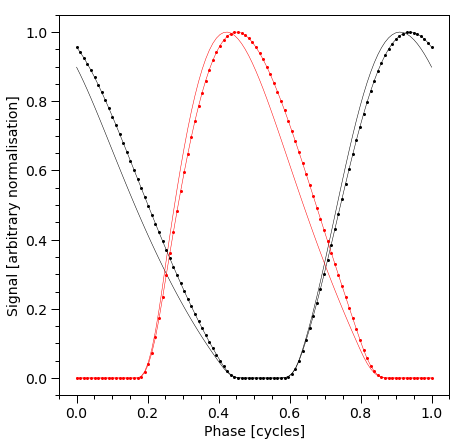

In [23]:
likelihood(p, reinitialise=True)
_ = plot_pulse()

The pulse profiles with markers are the signals incident on the telescope, before operating on them with the response model. The markers, linearly spaced in phase, denote the phase resolution.

The ``likelihood`` object calls the ``star.update`` method which in-turn calls the ``photosphere.embed`` method. The ``likelihood`` object then calls the ``photosphere.integrate`` method, passing the energies stored as the property ``pulse.energies``. We can do this manually if we wish to integrate pulses but not calculate likelihoods. Here we sum over incident specific photon flux pulses as an approximation to integrating over energy. Note that we do not change the ``pulse.pulses`` traced by the solid curves without markers.

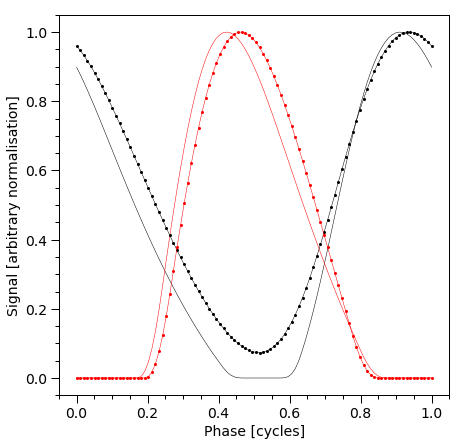

In [24]:
q = [0.2,
     1.4,
     12.5,
     1.0,
     1.0,
     0.075,
     6.2,
     math.pi - 1.0,
     0.2,
     6.0,
     0.0,
     0.025]

star.update(q, threads=3)
photosphere.integrate(energies=pulse.energies, threads=3)

_ = plot_pulse()

Below we print a crude representation of the cell mesh spanning the primary hot region (if you defocus your eyes the approximate circular region is clearer). The elements of the array which are finite are not all identical: at the boundary of the hot region the proper area elements are smaller such that the sum of all finite proper areas effectively equals the total proper area within the hot-region boundary.

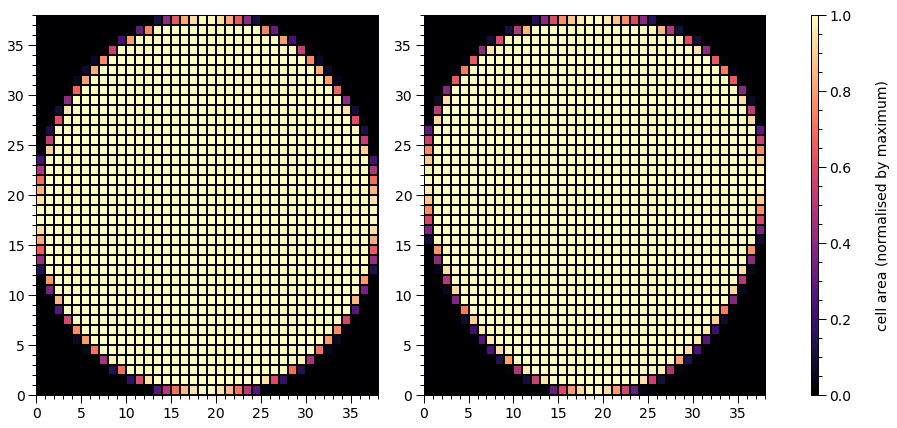

In [25]:
fig = plt.figure(figsize = (14,7))

gs = gridspec.GridSpec(1, 3, width_ratios=[50,50,1], wspace=0.2)
ax = plt.subplot(gs[0])
veneer((1,5), (1, 5), ax)

# primary (lower colatitude) hot region
z = hot._HotRegion__cellArea[0]/np.max(hot._HotRegion__cellArea[0])
patches = plt.pcolormesh(z,
                         vmin = np.min(z),
                         vmax = np.max(z),
                         cmap = cm.magma,
                         linewidth = 1.0,
                         rasterized = True,
                         edgecolor='black')

ax = plt.subplot(gs[1])
veneer((1,5), (1, 5), ax)

# secondary (higher colatitude) hot region
z = hot.cellArea[0]/np.max(hot.cellArea[0])
_ = plt.pcolormesh(z,
                   vmin = np.min(z),
                   vmax = np.max(z),
                   cmap = cm.magma,
                   linewidth = 1.0,
                   rasterized = True,
                   edgecolor='black')

ax_cb = plt.subplot(gs[2])
cb = plt.colorbar(patches,
                  cax = ax_cb,
                  ticks = MultipleLocator(0.2))

cb.set_label(label = r'cell area (normalised by maximum)', labelpad=25)
cb.solids.set_edgecolor('face')

veneer(None, (0.05, None), ax_cb)
cb.outline.set_linewidth(1.0)

Note that the lowest colatitude row is at zero on the y-axis.

Let's plot a pulse in two dimensions. Also note that we can interpolate the signal in phase as follows.

In [26]:
from xpsi.tools import phase_interpolator

In [27]:
def plot_2D_pulse(z, x, shift, y, ylabel, num_rotations=5.0, res=5000, cm=cm.viridis):
    """ Helper function to plot a phase-energy pulse.
    
    :param array-like z:
        A pair of *ndarray[m,n]* objects representing the signal at
        *n* phases and *m* values of an energy variable.
        
    :param ndarray[n] x: Phases the signal is resolved at.
        
    :param tuple shift: Hot region phase parameters.
    
    :param ndarray[m] x: Energy values the signal is resolved at.
    
    """
    
    fig = plt.figure(figsize = (12,6))

    gs = gridspec.GridSpec(1, 2, width_ratios=[50,1], wspace=0.025)
    ax = plt.subplot(gs[0])
    ax_cb = plt.subplot(gs[1])

    new_phases = np.linspace(0.0, num_rotations, res)

    interpolated = phase_interpolator.interpolate_pulse(new_phases,
                                                        x,
                                                        z[0], shift[0])
    interpolated += phase_interpolator.interpolate_pulse(new_phases,
                                                         x,
                                                         z[1], shift[1])

    profile = ax.pcolormesh(new_phases,
                             y,
                             interpolated/np.max(interpolated),
                             cmap = cm,
                             linewidth = 0,
                             rasterized = True)

    profile.set_edgecolor('face')

    ax.set_xlim([0.0, 5.0])
    ax.set_yscale('log')
    ax.set_ylabel(ylabel)
    ax.set_xlabel(r'Phase')
    veneer((0.1, 0.5), (None,None), ax)

    cb = plt.colorbar(profile,
                      cax = ax_cb,
                      ticks = MultipleLocator(0.2))

    cb.set_label(label=r'Signal (normalised by maximum)', labelpad=25)
    cb.solids.set_edgecolor('face')

    veneer(None, (0.05, None), ax_cb)
    cb.outline.set_linewidth(1.0)

The incident specific flux signal, in units of photons/cm$^{2}$/s/keV:

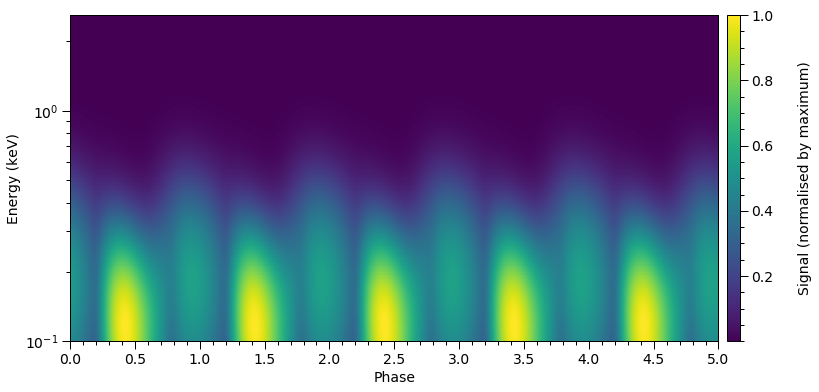

In [28]:
plot_2D_pulse((photosphere.pulse[0][0], photosphere.pulse[1][0]),
              x=pulse.phases,
              shift=p[-2:],
              y=pulse.default_energies,
              ylabel=r'Energy (keV)')

The count rate signal in each channel:

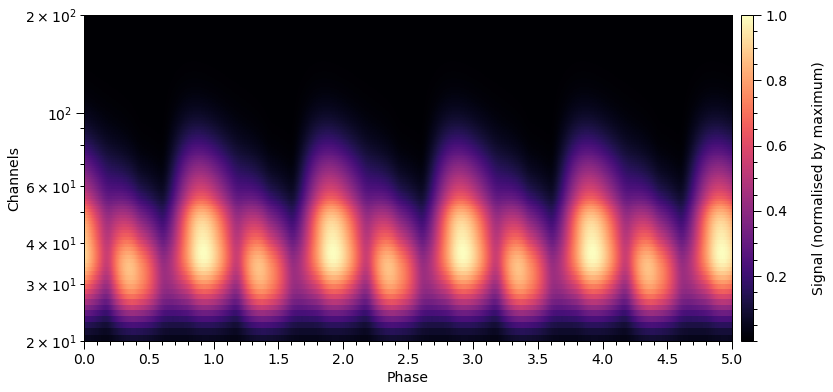

In [29]:
plot_2D_pulse((pulse.pulse[0], pulse.pulse[1]),
              x=pulse.phases,
              shift=p[-2:],
              y=NICER.channels,
              ylabel=r'Channels',
              cm=cm.magma)

Now we use parameter vector ``q``, increase the phase resolution, and plot a single rotational pulse.

In [30]:
hot.set_phases(num_leaves = 1024)
_ = likelihood(q, reinitialise = True)

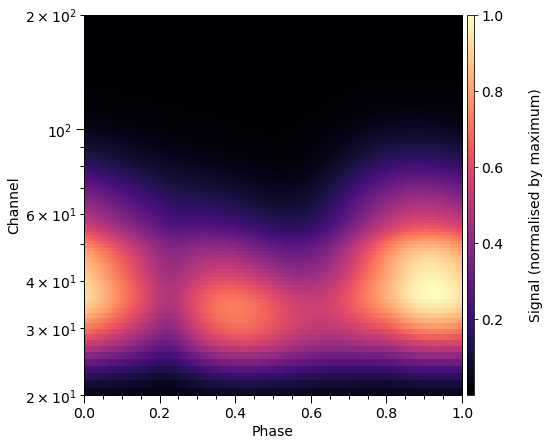

In [31]:
temp = pulse.pulse[0] + pulse.pulse[1]

# the count rate signal is normalised with respect to the global maximum
# over channels and phase of the joint signal from the hot regions
plot_one_pulse(temp/np.max(temp), pulse.phases, r'Signal (normalised by maximum)')

Let's iterate over a monotonically increasing set of values of the hot-region angular radius. Note that we use the keyword ``threads`` to directly instruct the low-level routines how many OpenMP threads to spawn to accelerate the computation. Usually the ``likelihood`` object instructs the low-level routines how many threads to spawn, based on it's ``thread`` property:

In [32]:
likelihood.threads

1

Given that we are not currently using the ``likelihood`` object as a callback function passed to posterior sampling software (which parallelises efficiently using Open MPI), we can safely spawn additional worker threads for pulse integration; if likelihood evaluations are parallelised in an Open MPI environment on the other hand, one risks *losing* efficiency by spawning worker threads for likelihood evaluation.

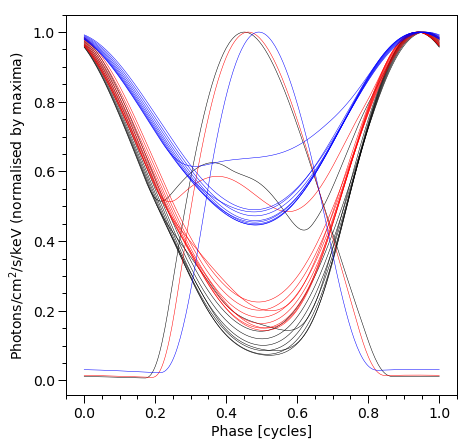

In [33]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
ax.set_ylabel('Photons/cm$^2$/s/keV (normalised by maxima)')
ax.set_xlabel('Phase [cycles]')

hot.set_phases(num_leaves = 256)

# let's play with the angular radius of the primary hot region
angular_radii = np.linspace(0.01, 1.0, 10)

q = list(p) # copy

for angular_radius in angular_radii:
    q[5] = angular_radius
    star.update(q, threads=3)
    photosphere.integrate(energies=pulse.energies, threads=3)
    temp = np.sum(photosphere.pulse[1][0], axis=0) + np.sum(photosphere.pulse[0][0], axis=0)
    _ = ax.plot(hot.phases_in_cycles, temp/np.max(temp), 'k-', lw=0.5)

q = list(p)
q[3] = 1.0 # change inclination
    
for angular_radius in angular_radii:
    q[5] = angular_radius
    star.update(q, threads=3)
    photosphere.integrate(energies=pulse.energies, threads=3)
    temp = np.sum(photosphere.pulse[1][0], axis=0) + np.sum(photosphere.pulse[0][0], axis=0)
    _ = ax.plot(hot.phases_in_cycles, temp/np.max(temp), 'r-', lw=0.5)

q = list(p)
q[3] = 0.5

for angular_radius in angular_radii:
    q[5] = angular_radius
    star.update(q, threads=3)
    photosphere.integrate(energies=pulse.energies, threads=3)
    temp = np.sum(photosphere.pulse[1][0], axis=0) + np.sum(photosphere.pulse[0][0], axis=0)
    _ = ax.plot(hot.phases_in_cycles, temp/np.max(temp), 'b-', lw=0.5)
    
veneer((0.05,0.2), (0.05,0.2), ax)

## Prior

Let us now construct a callable object representing a joint prior density distribution on the space $\mathbb{R}^{d}$. We need to extend the base class to implement our distribution, which in all but two dimensions is separable and *uniform* on some compact interval of the space. The exceptions are the gravitational mass and equatorial radius: a joint constraint is imposed to assign zero density to stars which are *too* compact (the polar radius of the rotationally deformed stellar 2-surface is close to the radius of the Schwarzschild photon sphere), but the joint prior density is *uniform* otherwise between hard bounds on each parameter.

In [34]:
from scipy.stats import truncnorm

In [35]:
class CustomPrior(xpsi.Prior):
    """ A custom (joint) prior distribution.
    
    Source: Fictitious
    Model variant: ST-U
        Two single-temperature, simply-connected circular hot regions with
        unshared parameters.
    
    Parameter vector:
    
        * p[0] = distance (kpc)
        * p[1] = (rotationally deformed) gravitational mass (solar masses)
        * p[2] = coordinate equatorial radius (km)
        * p[3] = inclination of Earth to rotational axis (radians)
        * p[4] = primary region centre colatitude (radians)
        * p[5] = primary region angular radius (radians)
        * p[6] = primary region log10(local comoving blackbody temperature [K])
        * p[7] = secondary region centre colatitude (radians)
        * p[8] = secondary region angular radius (radians)
        * p[9] = secondary region log10(local comoving blackbody temperature [K])
        * p[10] = primary region phase shift (cycles); (alias for initial azimuth, periodic)
        * p[11] = secondary region phase shift (cycles)
    
    """
    def __init__(self, bounds, spacetime):
        """
        :param obj spacetime:
            Bit of a hack to access spacetime properties for defining
            the support of the prior.
        
        """
        # Execute abstract parent initialiser
        super(CustomPrior, self).__init__(bounds)

        assert isinstance(spacetime, xpsi.Spacetime),\
                'Invalid type for ambient spacetime object.'

        self._spacetime = spacetime

    def __call__(self, p):
        """ Evaluate distribution at :obj:`p`.
        
        :param list p: Model parameters values.
        
        :returns: Logarithm of the distribution evaluated at :obj:`p`.
        
        """
        for i, b in enumerate(self._bounds):
            if None not in b:
                if not b[0] <= p[i] <= b[1]:                                                                                                        
                    return -np.inf
        
        i = self._spacetime.num_params
        # update and access spacetime properties
        self._spacetime.update(*p[:i])

        # based on contemporary EOS theory
        if not self._spacetime.R <= 16.0*_km:
            return -np.inf

        # photon sphere
        if not 1.5 < self._spacetime.R_r_s:
            return -np.inf

        epsilon = self._spacetime.epsilon
        zeta = self._spacetime.zeta
        mu = math.sqrt(-1.0 / (3.0 * epsilon * (-0.788 + 1.030 * zeta)))

        # 2-surface cross-section have a single maximum in |z|
        # i.e., an elliptical surface; minor effect on support
        if mu < 1.0:
            return -np.inf

        R_p = 1.0 + epsilon * (-0.788 + 1.030 * zeta)
        
        # polar radius causality for ~static star (static ambient spacetime)
        # if R_p < 1.5 / self._spacetime.R_r_s:
        #     return -np.inf

        # limit polar radius to try to exclude deflections >= \pi radians
        if R_p < 1.76 / self._spacetime.R_r_s:
            return -np.inf
        
        # enforce order in hot region colatitude
        if p[4] > p[7]:
            return -np.inf

        theta_p = p[4]
        phi = (p[10] - 0.5 - p[11]) * _2pi
        rho_p = p[5]

        theta_s = p[7]
        rho_s = p[8]

        ang_sep = xpsi.HotRegion._psi(theta_s, phi, theta_p)

        # hot regions cannot overlap
        if ang_sep < rho_p + rho_s:
            return -np.inf

        return 0.0

    def inverse_sample(self, hypercube):
        """ Draw sample uniformly from the distribution via inverse sampling. """
        
        p = super(CustomPrior, self).inverse_sample(hypercube)

        # distance
        p[0] = truncnorm.ppf(hypercube[0], -2.0, 7.0, loc=0.3, scale=0.1)

        # phase of primary hot region
        if p[10] > 0.5:
            p[10] -= 1.0

        # phase of secondary hot region
        if p[11] > 0.5:
            p[11] -= 1.0

        return p

    def inverse_sample_and_transform(self, hypercube):

        p = self.transform(self.inverse_sample(hypercube))

        return p
    
    inverse_sample_and_transform.__doc__ = xpsi.Prior.inverse_sample_and_transform.__doc__

    @staticmethod
    def transform(p):
        """ A transformation for post-processing. """

        if not isinstance(p, list):
            p = list(p)
        
        # compactness ratio M/R_eq
        p += [gravradius(p[1]) / p[2]]
        
        # phase transforms
        if p[10] < 0.0:
            tempp = p[10] + 1.0
        else:
            tempp = p[10]
        
        temps = 0.5 + p[11]
        
        # phase separation
        if temps >= tempp:
            p += [temps - tempp]
        else:
            p += [1.0 - tempp + temps]
        
        # angle combinations
        p += [p[3] - p[4]]
        p += [p[3] + p[4]]
        p += [p[3] - p[7]]

        return p

We can now construct and instantiate a callable ``prior`` object, passing the bounds from the ``likelihood`` object.

In [36]:
prior = CustomPrior(bounds = likelihood.bounds, spacetime = spacetime)

prior(p)

0.0

The ``prior.inverse_sample()`` method can be used to initialise the ensemble of walkers evolved by [emcee](http://emcee.readthedocs.io/en/latest/), and is required by [MultiNest](https://github.com/farhanferoz/MultiNest) to uniformly sample from the prior distribution and transform it into a posterior distribution. Let's call the method, passing a vector of pseudorandom numbers drawn when each is drawn from a uniform distribution on the interval $[0,1)$:

In [37]:
prior.inverse_sample(np.random.rand(prior.ndims))

[0.19673973920994908,
 2.3013164769865364,
 5.848736690020468,
 1.2645733668472785,
 0.7014537683408584,
 1.0384071991803774,
 5.659726995961641,
 1.845734173923105,
 1.518740337396574,
 6.336255177184295,
 -0.37149356399054045,
 -0.24193199149615263]

## Sampling interface

We have constructed and instantiated both a callable ``likelihood`` object and a callable ``prior`` object. We could proceed, for example, to apply the open-source sampler [emcee](http://emcee.readthedocs.io/en/latest/) to the joint posterior distribution proportional to the product of the (exponentiated) calls to the ``likelihood`` and ``prior`` objects.

### Ensemble MCMC

To prove that the objects constructed above can be fed to the ``emcee`` sampler, let's run a few iterations using a single process. We will initialise the ensemble by drawing from a multivariate Gaussian with mean vector equal to the ground truth vector.

In [39]:
std = [0.01,
         0.05,
         0.1,
         0.01,
         0.05,
         0.0025,
         0.01,
         0.05,
         0.05,
         0.01,
         0.01,
         0.01]

In [40]:
runtime_params = {'resume': True,
                  'root_dir': './',
                  'nwalkers': 50,
                  'nsteps': 10,
                  'walker_dist_moments': None} # if not resume: zip(p, std)

hot.set_phases(num_leaves = 100)
likelihood.threads = 4
likelihood.reinitialise()

# Use MPI=False for testing purposes
backend = xpsi.Sample.ensemble(likelihood, prior,
                               MPI=False, **runtime_params) 

  0%|          | 0/10 [00:00<?, ?it/s]

Imported emcee version: 3.0.1

Commencing posterior sampling.


100%|██████████| 10/10 [04:49<00:00, 28.94s/it]


Sampling complete.


In [ ]:
# clean up the docs/source directory
#!rm samples.h5; rm -r old_samples

Note that we could also try initialising the ensemble by inverse sampling the joint prior distribution. Initially the iteration time should increase because a non-negligible fraction of move proposals will be where the prior density is zero and thus the likelihood is not evaluated. As the ensemble migrates to higher posterior densities the iteration time will increase and then stabilise.

Let's quickly plot the evolution of the ensemble Markov chains to prove that the sampling process commenced and is behaving in a somewhat reasonable manner:

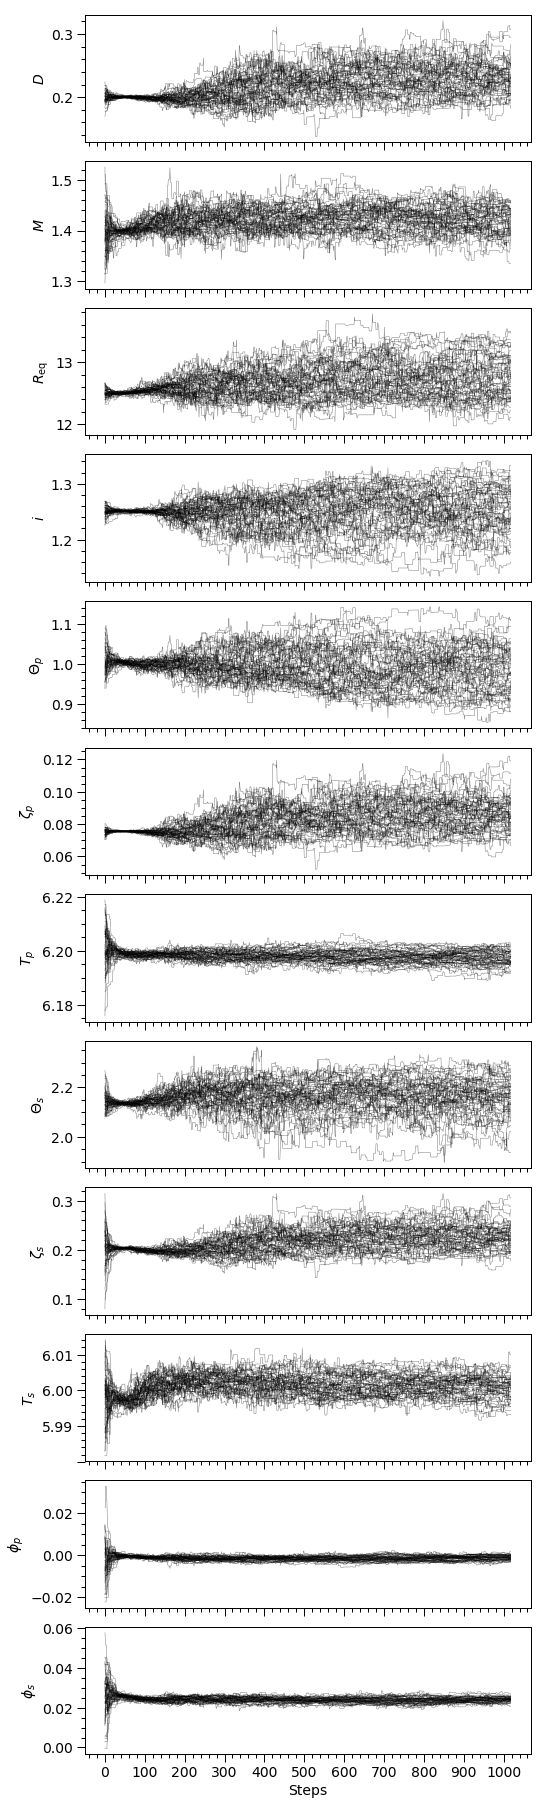

In [41]:
try:
    backend
except NameError:
    import emcee
    backend = emcee.backends.HDFBackend('samples.h5')
    
chain = backend.get_chain()

labels = [r'$D$',
          r'$M$',
          r'$R_{\rm eq}$',
          r'$i$',
          r'$\Theta_{p}$',
          r'$\zeta_{p}$',
          r'$T_{p}$',
          r'$\Theta_{s}$',
          r'$\zeta_{s}$',
          r'$T_{s}$',
          r'$\phi_{p}$',
          r'$\phi_{s}$']

fig = plt.figure(figsize=(8,32))
          
gs = gridspec.GridSpec(12, 1, hspace=0.15)
          
for i in range(len(labels)):
    ax = plt.subplot(gs[i,0])
    ax.set_ylabel(labels[i])
    for j in range(50):
        plt.plot(chain[:,j,i], 'k-', lw=0.5, alpha=0.5)
    if i < 11:
        ax.tick_params(axis='x', labelbottom=False)
        plt.setp(ax.get_yticklabels()[0], visible=False)
        plt.setp(ax.get_yticklabels()[-1], visible=False)
    else: ax.set_xlabel('Steps')
    veneer((20, 100), None, ax)

plt.subplots_adjust(hspace=0.15)

### Nested sampling

We interface with the nested sampler MultiNest in a similar manner, by defining some runtime settings, and then passing those settings together with ``likelihood`` and ``prior`` objects to a wrapper from the [Sample](sample.rst) module.

In [ ]:
runtime_params = {'resume': False,
                  'importance_nested_sampling': False,
                  'multimodal': False,
                  'n_clustering_params': None,
                  'outputfiles_basename': './nsrun/run',
                  'n_iter_before_update': 50,
                  'n_live_points': 50,
                  'sampling_efficiency': 0.8,
                  'const_efficiency_mode': False,
                  'wrapped_params': [0,0,0,0,0,0,0,0,0,0,1,1],
                  'evidence_tolerance': 0.5,
                  'max_iter': 1000,
                  'verbose': True}

likelihood.threads=4
# NB: the likelihood object needs to know about the prior for nested sampling:
likelihood.prior = prior

xpsi.Sample.nested(likelihood, prior, **runtime_params)

Imported PyMultiNest.
Commencing integration...
Estimating fractional hypervolume of the unit hypercube with finite prior density:
Requiring 1E+05 draws from the prior support for Monte Carlo estimation...
The support occupies an estimated 6.9% of the hypervolume within the unit hypercube...
Fractional hypervolume estimated.
Sampling efficiency set to: 11.5326.


The verbose output of the MultiNest program is by default directed to the host terminal session. Instead of trying to redirect that output to that of the above cell, we simply copy and paste the output from the terminal below:

    *****************************************************
    MultiNest v3.11
    Copyright Farhan Feroz & Mike Hobson
    Release Apr 2018

    no. of live points =  100

    dimensionality =   12
    *****************************************************
    Starting MultiNest
    generating live points
     live points generated, starting sampling
    Acceptance Rate:                        0.724638
    Replacements:                                100
    Total Samples:                               138
    Nested Sampling ln(Z):            **************
    Acceptance Rate:                        0.649351
    Replacements:                                150
    Total Samples:                               231
    Nested Sampling ln(Z):            -116670.287917
    Acceptance Rate:                        0.569801
    Replacements:                                200
    Total Samples:                               351
    Nested Sampling ln(Z):            -115291.669431
    Acceptance Rate:                        0.449640
    Replacements:                                250
    Total Samples:                               556
    Nested Sampling ln(Z):            -108499.449911
    Acceptance Rate:                        0.408719
    Replacements:                                300
    Total Samples:                               734
    Nested Sampling ln(Z):             -95430.022790
    Acceptance Rate:                        0.367261
    Replacements:                                350
    Total Samples:                               953
    Nested Sampling ln(Z):             -77360.112633
    Acceptance Rate:                        0.319744
    Replacements:                                400
    Total Samples:                              1251
    Nested Sampling ln(Z):             -66119.380404
    Acceptance Rate:                        0.263930
    Replacements:                                450
    Total Samples:                              1705
    Nested Sampling ln(Z):             -57607.930990
    Acceptance Rate:                        0.213675
    Replacements:                                500
    Total Samples:                              2340
    Nested Sampling ln(Z):             -53505.956949
    Acceptance Rate:                        0.173119
    Replacements:                                550
    Total Samples:                              3177
    Nested Sampling ln(Z):             -50428.177797
    Acceptance Rate:                        0.147893
    Replacements:                                600
    Total Samples:                              4057
    Nested Sampling ln(Z):             -47108.755667
    Acceptance Rate:                        0.132653
    Replacements:                                650
    Total Samples:                              4900
    Nested Sampling ln(Z):             -43437.007007
    Acceptance Rate:                        0.125381
    Replacements:                                700
    Total Samples:                              5583
    Nested Sampling ln(Z):             -39888.092691
    Acceptance Rate:                        0.113533
    Replacements:                                750
    Total Samples:                              6606
    Nested Sampling ln(Z):             -36841.337131

## Synthesis

In this notebook thus far we have not generated sythetic data. However, we did condition on synthetic data. Below we outline how that data was generated.

### Background

The background radiation field incident on the model instrument for the purpose of generating synthetic data was a time-invariant powerlaw spectrum, and was transformed into a count-rate in each output channel using the response matrix for synthetic data generation. We would reproduce this background here by writing a custom subclass as follows.

In [ ]:
class CustomBackground(xpsi.Background):
    """ The background injected to generate synthetic data. """

    def __init__(self, num_params, bounds):
        super(CustomBackground, self).__init__(num_params, bounds)

    def __call__(self, p, energy_edges, phases):
        """ Evaluate the incident background field. """
        Gamma = p[0]

        temp = np.zeros((energy_edges.shape[0] - 1, phases.shape[0]))

        temp[:,0] = (energy_edges[1:]**(Gamma + 1.0) - energy_edges[:-1]**(Gamma + 1.0)) / (Gamma + 1.0)

        for i in range(phases.shape[0]):
            temp[:,i] = temp[:,0]

        self.background = temp

Note that the analytic background is integrated over energy intervals, as required by a ``Pulse`` instance, which would then straightforwardly apply the model instrument response to the background.

We can now construct and instantiate a ``background`` object. The base clase ``xpsi.Background`` is inherited from the [parameter subspace](parameterSubspace.rst#xpsi.ParameterSubspace.ParameterSubspace) ABC. We therefore need to specify the number of background parameters, and define the hard bounds on those parameters; in this case we have only a single parameter, the powerlaw index.

We would then instantiate as follows:

In [ ]:
background = CustomBackground(num_params = 1, bounds = [(-3.0, -1.1)])

### Data format

We are also in need of a simpler data object.

In [ ]:
class SynthesiseData(xpsi.Data):
    """ Custom data container to enable synthesis. """
    
    def __init__(self, first, last, phases):
        """
        :param phase_edges: A :class:`numpy.ndarray` of phase interval edges.

        """
        # Execute parent initialisation code
        super(SynthesiseData, self).__init__(first, last)

        self._phases = phases

    @property
    def phases(self):
        """ Get the phase edges. """
        return self._phases

Instantiate:

In [ ]:
_data = SynthesiseData(0, 181, phases = np.linspace(0.0, 1.0, 33))

### Custom method

We are in need of a ``synthesise`` method, which in this implementation wraps an extension module. Let's check what the extension module offers:

In [ ]:
from xpsi.tools.synthesise import synthesise as _synthesise

In [ ]:
_synthesise()

In [ ]:
def synthesise(self, p,
               require_source_counts,
               require_background_counts,
               name='synthetic',
               directory='./data',
               **kwargs):
        """ Synthesise data set.

        * p[0] = phase shift primary (alias for initial azimuth/phase of photosphere)
        * p[1] = phase shift secondary

        """
        self.shift = np.array(p)

        self._expected_counts, synthetic = _synthesise(self._data.phases,
                                            require_source_counts,
                                            require_background_counts,
                                            self._pulse,
                                            self._phases,
                                            self._background.folded_background,
                                            self._shift)
        try:
            if not os.path.isdir(directory):
                os.mkdir(directory)
        except OSError:
            print('Cannot create write directory.')
            raise

        np.savetxt(os.path.join(directory, name+'_realisation.dat'),
                   synthetic,
                   fmt = '%u')

        self._write(self.expected_counts,
                    filename = os.path.join(directory, name+'_expected_hreadable.dat'),
                    fmt = '%.8e')

        self._write(synthetic,
                    filename = os.path.join(directory, name+'_realisation_hreadable.dat'),
                    fmt = '%u')

def _write(self, counts, filename, fmt):
    """ Write to file in human readable format. """

    rows = len(self._data.phases) - 1
    rows *= self._data.channel_range[1] - self._data.channel_range[0]

    phases = self._data.phases[:-1]
    array = np.zeros((rows, 3))

    for i in range(counts.shape[0]):
        for j in range(counts.shape[1]):
            array[i*len(phases) + j,:] = i+20, phases[j], counts[i,j]

    np.savetxt(filename, array, fmt=['%u', '%.6f'] + [fmt])

Add unbound methods:

In [ ]:
CustomPulse.synthesise = synthesise
CustomPulse._write = _write

Instantiate, and reconfigure the likelihood object:

In [ ]:
pulse = CustomPulse(tag = 'all',
                    num_params = 2,
                    bounds = [(-0.25, 0.75), (-0.25, 0.75)],
                    data = _data,
                    instrument = NICER,
                    background = background,
                    interstellar = None,
                    energies_per_interval = 0.5,
                    default_energy_spacing = 'logspace',
                    fast_rel_energies_per_interval = 0.5,
                    workspace_intervals = 1000,
                    adaptive_energies = False,
                    store = True,
                    epsrel = 1.0e-8,
                    epsilon = 1.0e-3,
                    sigmas = 10.0)

hot.set_phases(num_leaves = 100)
likelihood = xpsi.Likelihood(star = star, pulses = pulse, threads=1)

### Synthesise

We proceed to synthesise. First we set an environment variable to seed the random number generator being called:

In [ ]:
%env GSL_RNG_SEED=0

Check write path:

In [ ]:
!pwd

In [ ]:
p = [0.2,
     1.4,
     12.5,
     1.25,
     1.0,
     0.075,
     6.2,
     math.pi - 1.0,
     0.2,
     6.0,
     -2.0,
     0.0,
     0.025]

likelihood.synthesise(p,
                      require_source_counts=2.0e6,
                      require_background_counts=2.0e6,
                      name='synthetic',
                      directory='./data') # SEED=0

In [ ]:
plot_one_pulse(np.loadtxt('data/synthetic_realisation.dat', dtype=np.double), _data.phases)

Check we have generated the same count numbers, given the same seed and resolution settings:

In [ ]:
diff = data.counts-np.loadtxt('data/synthetic_realisation.dat', dtype=np.double)
(diff != 0.0).any()

## Summary